In [5]:
import gfapy
import networkx as nx
import gzip
import pyfrost
import numpy
from collections import defaultdict
import matplotlib.pyplot as plot
import sys
sys.path.append('../MHC_asm/')
import CCGG_extension as CCGG

In [6]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_graph_Bfrost_graph.gfa'
g = pyfrost.load(filename)

In [7]:
len(g.graph['color_names']), g.graph

(47,
 {'color_names': ['/cromwell_root/fc-50f5097c-c1b5-4611-9f49-ce88d43f76c7/submissions/70921fb0-e031-421e-9eaa-da7c2962d165/ExtractBam/3ba859de-b4a4-49a1-950f-bbf38046ad95/call-extract_bam/cacheCopy/HG002.fasta',
   '/cromwell_root/fc-50f5097c-c1b5-4611-9f49-ce88d43f76c7/submissions/70921fb0-e031-421e-9eaa-da7c2962d165/ExtractBam/92f09703-79a9-4ec5-b3ff-6ef142e7d228/call-extract_bam/HG00438.fasta',
   '/cromwell_root/fc-50f5097c-c1b5-4611-9f49-ce88d43f76c7/submissions/70921fb0-e031-421e-9eaa-da7c2962d165/ExtractBam/91b6c3f5-3905-4a1e-8f43-6f5322ee8ccc/call-extract_bam/HG00621.fasta',
   '/cromwell_root/fc-50f5097c-c1b5-4611-9f49-ce88d43f76c7/submissions/70921fb0-e031-421e-9eaa-da7c2962d165/ExtractBam/f1e37328-ca34-4149-a67d-4e785af9dbf7/call-extract_bam/HG00673.fasta',
   '/cromwell_root/fc-50f5097c-c1b5-4611-9f49-ce88d43f76c7/submissions/70921fb0-e031-421e-9eaa-da7c2962d165/ExtractBam/24231b6e-8fd7-4c6e-9893-96c2d9fe5f13/call-extract_bam/HG00733.fasta',
   '/cromwell_root/fc-50f50

In [8]:
def revised_find_shared_kmers(g, k, colorsnum):
    anchorlist = []
    no_colors = 0
    for n, data in g.nodes(data=True):
        unitig = data['unitig_sequence']
        for i in range(len(unitig)- k + 1):
            n = unitig[i:i+k]
            try:
                colors = g.nodes[pyfrost.Kmer(n)]['colors'] 
                if len(set(colors)) == colorsnum:
                    anchorlist.append(n)
                    break
            except:
                no_colors += 1
                
    return anchorlist, no_colors

anchorlist, no_colors = revised_find_shared_kmers(g, 11, 47)
no_colors, len(anchorlist)

(110332, 18228)

In [9]:
nodes = []
for n, data in g.nodes(data=True):
    nodes.append((n, len(data['colors'])))
    num = 0
    for c in data['colors']:
        num+=1
    nodes.append((n, num))
    # print("Node", n, "has color", num)

RuntimeError: Invalid colorset for unitig! Got a nullptr...

In [10]:
len(list(g.nodes)), no_colors, no_colors/len(list(g.nodes))

(405528, 110332, 0.2720699927008739)

In [11]:
# map to reference, delete duplicated or missing kmers (exist in reverse complement strand)
refgenome = '/home/suhang/assembly_disk/Mitochondrial/NC_012920.1.fasta'
with open(refgenome, 'r') as fp:
    data = fp.readlines()
kmers = [k[:-1] for k in data[1:]]
contig = "".join(kmers)

In [12]:
len(contig), contig[:100]

(16569,
 'GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCATGCATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTGCGAGACGCTG')

In [13]:
contig = "+" + contig # reference sequences
def map_to_genome(contig, anchorlist, k):
    PositionDict = defaultdict(list)
    for anchor in anchorlist:
        PositionDict[anchor]
    for i in range(1, len(contig) - k + 1):
        kmer = contig[i:i+k]
        if kmer in PositionDict:
            PositionDict[kmer] = PositionDict.get(kmer, []) + [i]
    return PositionDict

PositionDict = map_to_genome(contig, anchorlist, 11)

In [14]:
def create_anchors(PositionDict, k):
    anchor_updated_list = []

    for kmer in PositionDict:
        if len(PositionDict[kmer]) == 1:
            anchor_updated_list.append(kmer)
    AnchorInfo = {}
    for kmer in anchor_updated_list:
        pos = PositionDict[kmer][0]
        anchorname = "A%06d" %  (pos//k + 1)
        AnchorInfo[anchorname] = {}
        AnchorInfo[anchorname]['seq'] = kmer
        AnchorInfo[anchorname]['pos'] = pos
        
    anchornames = sorted(AnchorInfo.keys())
    anchor_unadjacent_list = []
    index = 0
    sanchor = anchornames[index]
    while sanchor < anchornames[-1]:
        for danchor in anchornames[index+1:]:
            index += 1
            if AnchorInfo[danchor]['pos'] - AnchorInfo[sanchor]['pos'] > 11:
                break
        anchor_unadjacent_list += [sanchor, danchor]
        sanchor = danchor
    anchor_unadjacent_list = sorted(set(anchor_unadjacent_list))
    return AnchorInfo, anchor_unadjacent_list

In [15]:
k = 11
AnchorInfo, anchor_unadjacent_list = create_anchors(PositionDict, k)

In [16]:
# sort anchor position, delete overlapping anchors
len(AnchorInfo)

762

In [17]:
#anchor_unadjacent_list = sorted(set(anchor_unadjacent_list))
print(len(anchor_unadjacent_list), len(AnchorInfo))
pos1 = [AnchorInfo[anchor]['pos'] for anchor in anchor_unadjacent_list[1:]]
pos = [AnchorInfo[anchor]['pos'] for anchor in anchor_unadjacent_list[:-1]]
numpy.where((numpy.array(pos1) - numpy.array(pos))<=11)

592 762


(array([], dtype=int64),)

In [18]:
Final_anchor = {anchor:AnchorInfo[anchor] for anchor in anchor_unadjacent_list}
len(Final_anchor)

592

# Find path between each pair of anchors by registing the raw reads

In [19]:
# load raw reads
def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into a list of headers 
        and fragment sequences for each sequence contained.
        The resulting sequences are 0-indexed! """
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'rb')
    else:
        fp = open(filename, 'rb')
    # split at headers
    data = fp.read().decode().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        sequences.append(''.join(lines))
    return (headers, sequences)


In [81]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/HPRC_46_sample_input.fasta.gz'
headers, sequences = loadFasta(filename)

In [82]:
refgenome = '/home/suhang/assembly_disk/Mitochondrial/NC_012920.1.fasta'
with open(refgenome, 'r') as fp:
    data = fp.readlines()
kmers = [k[:-1] for k in data[1:]]
contig = "".join(kmers)

headers.append('NC_012920')
sequences.append(contig)

In [83]:
len(headers)/47, len(headers), sum([len(seq) for seq in sequences])

(253.68085106382978, 11923, 191670673)

In [86]:
len(anchor_unadjacent_list), len(sequences[-1])

(592, 16569)

In [87]:


def mapping_info(Anchorseq, contig, k):
    seqlist = Anchorseq.keys()
    PositionDict = defaultdict(list)
    for anchor_seq in seqlist:
        anchor_rev = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(anchor_seq)])
        PositionDict[anchor_seq]
        PositionDict[anchor_rev]

    for i in range(1, len(contig) - k + 1):
        kmer = contig[i:i+k]
        if kmer in PositionDict:
            PositionDict[kmer] = PositionDict.get(kmer, []) + [i]
            
    A = {}
    SVs = {}
    for anchor in anchor_unadjacent_list:
        anchor_seq = AnchorInfo[anchor]['seq']
        anchor_rev = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(anchor_seq)])
        poslist = PositionDict[anchor_seq] + PositionDict[anchor_rev]
        if len(poslist) == 1:
            A[anchor] = poslist[0]
        else:
            SVs[anchor] = poslist
            
    return A, SVs

def find_edge_info(src_pos, dst_pos, k, contig, contigname, Anchorseq):
    E = {} # edgeinfo
    # get source infomation
    if src_pos == 0:
        src = "SOURCE"
        src_seq = ""
        pr = False
    else:
        src_seq = contig[src_pos:src_pos + k]
        try:
            src = Anchorseq[src_seq]
            pr = False
        except:
            src_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(src_seq)])
            src = Anchorseq[src_seq]
            pr = True

    dst_seq = contig[dst_pos:dst_pos+k]
    
    if dst_pos == len(contig): # fix sink edge issue 08/29/23
        dst = "SINK"
        dst_seq = ""
        sr = True
    else:
        try:
            dst = Anchorseq[dst_seq]
            sr = False
        except:
            dst_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(dst_seq)])
            dst = Anchorseq[dst_seq]
            sr = True
            
    if src_pos == 0:
        edge_seq = contig[src_pos:dst_pos] # first edge fix bug 08/28/2023
    else:
        edge_seq = contig[src_pos+k:dst_pos] # fix bug 08/23/2023
        
    if pr and sr:
        edge_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(edge_seq)])
        node = src
        src = dst
        dst = node

    
    E = {}
    E['seq'] = edge_seq
    E['src'] = src
    E['dst'] = dst
    E['reads'] = [contigname]


    return E


In [88]:
# contig_name = headers[-1]
# contig = sequences[-1]
# print(ref, len(ref_contig))
# A, SVs = mapping_info(Anchorseq, contig, k)
# #A == {anchor: Final_anchor[anchor]['pos'] for anchor in Final_anchor}
# splitposlist = sorted(A.values())
# edgeindex = 0 # 
# src_pos = 0

# for dst_pos in splitposlist:
#     E = find_edge_info(src_pos, dst_pos, k, contig, contig_name, Anchorseq)
#     print(E)
#     src = E['src']
#     edgelist = Outgoing.get(src, [])
#     for edge in edgelist:
#         if Edge_info[edge]['dst'] != E['dst']:
#             continue
#         if Edge_info[edge]['seq'] == E['seq']:
#             Edge_info[edge]['reads'] += E['reads']
#             break
#     else:
#         edgename = "E%05d.%04d" % (contig_index, edgeindex)
#         Edge_info[edgename] = E
#         Outgoing[src] = Outgoing.get(src,[]) + [edgename]
#         edgeindex += 1
#     # update
#     src_pos = dst_pos
#     break

In [89]:
# loop through all reads
def create_edgefile(headers, sequences, Anchorseq):
    Edge_info = {}
    Outgoing = {}
    
    edgenum_perread = []

    for contig_index in range(len(headers)):
        contig = sequences[contig_index]
        contig_name = headers[contig_index]
        A, SVs = mapping_info(Anchorseq, contig, k)
        splitposlist = sorted(A.values())
        edgeindex = 0 # 
        src_pos = 0
        for dst_pos in splitposlist:
            E = find_edge_info(src_pos, dst_pos, k, contig, contig_name, Anchorseq)
            src = E['src']
            edgelist = Outgoing.get(src, [])
            for edge in edgelist:
                if Edge_info[edge]['dst'] != E['dst']:
                    continue
                if Edge_info[edge]['seq'] == E['seq']:
                    Edge_info[edge]['reads'] += E['reads']
                    break
            else:
                edgename = "E%05d.%04d" % (contig_index, edgeindex)
                Edge_info[edgename] = E
                Outgoing[src] = Outgoing.get(src,[]) + [edgename]
                edgeindex += 1
            # update
            src_pos = dst_pos
        
        dst_pos = len(contig) # fix bug 08/29/2023 
        E = find_edge_info(src_pos, dst_pos, k, contig, contig_name, Anchorseq)
        src = E['src']
        edgelist = Outgoing.get(src, [])
        for edge in edgelist:
            if Edge_info[edge]['dst'] != E['dst']:
                continue
            if Edge_info[edge]['seq'] == E['seq']:
                Edge_info[edge]['reads'] += E['reads']
                break
        else:
            edgename = "E%05d.%04d" % (contig_index, edgeindex)
            Edge_info[edgename] = E
            Outgoing[src] = Outgoing.get(src,[]) + [edgename]
            edgeindex += 1
        
        edgenum_perread.append(edgeindex)   
        
        
        
    return Edge_info, Outgoing
        #print(contig_name, edgeindex)




In [90]:
Anchorseq = {AnchorInfo[anchor]['seq']:anchor for anchor in anchor_unadjacent_list}
#k = 11
len(Anchorseq)

592

In [91]:
%time Edge_info, Outgoing = create_edgefile(headers, sequences, Anchorseq)

CPU times: user 3min 37s, sys: 19.6 ms, total: 3min 37s
Wall time: 3min 37s


In [92]:
# filter edges that supported by > 3 reads
ref = 'NC_012920'
deleted_edge = []
for edge in Edge_info:
    if ref in Edge_info[edge]['reads']:
        continue
    if len(Edge_info[edge]['reads']) < 4:
        deleted_edge.append(edge)
print(len(deleted_edge))
for edge in deleted_edge:
    del Edge_info[edge]

92403


In [93]:
len(Edge_info) # prev 16270+

12694

In [135]:
#"E00005.0067" in Edge_info

In [136]:
# merge edges 
# len(Edge_info)
# node = anchor_unadjacent_list[0]
# for edge in Outgoing[node]:
#     if edge in Edge_info:
#         print(edge,len(Edge_info[edge]['reads']), Edge_info[edge]['seq'])

In [94]:
# Write Graph into GFA files
def write_gfa(AnchorInfo, Edge_info, outputfilename, anchor_unadjacent_list):
    header = ['H\tVN:Z:1.0\n']
    AnchorS = ['S\t%s\t%s\n' % (anchor, AnchorInfo[anchor]['seq']) for anchor in anchor_unadjacent_list]
    EdgeS = ['S\t%s\t%s\n' % (edge, Edge_info[edge]['seq']) for edge in Edge_info]
    Link = [] 
    for edge in Edge_info:
        src = Edge_info[edge]['src']
        dst = Edge_info[edge]['dst']       
        Link.append('L\t%s\t%s\t%s\t%s\t%s\n'% (src, "+", edge, "+", "0M"))
        Link.append('L\t%s\t%s\t%s\t%s\t%s\n'% (edge, "+", dst, "+", "0M"))

    with open(outputfilename, 'w') as fp:
        for h in header:
            fp.write(h)
        for s in AnchorS:
            fp.write(s)
        for s in EdgeS:
            fp.write(s)
        for l in Link:
            fp.write(l)

In [95]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_anchor_graphical_genome_revised.gfa'
write_gfa(Final_anchor, Edge_info, filename, anchor_unadjacent_list)

In [96]:
# Write Graph into fa files
import ujson as json
def writeGraphFasta(filename, input_dict, keylist=["src", "dst"]):
    """Write the given node or edge file as a FASTA file. Overwrites existing file. Will create file if it doesn't exist. 
    def writeFasta(self:<GraphicalGenome>, filename:<str>, input_dict:<dict>, keylist=["src","dst"]:<list[str]>) -> Void

    Parameters:
        filename: <str> - absolute path for the file you wish to write. 
        input_dict: <dict> - Node or Edge dictionary you wish to write. 
        keylist: <list[str]> - list of strings of dictionary keys that you want to ignore during write. 
                This will require you to write these values on your own or just discard them. 
    """
    sorted_keys = sorted(input_dict.keys()) 
    with open(filename, "w+") as fastafile:
        # If iterating through the edges, write the edges in the correctly ordered format
        if (sorted_keys[0][0] == "E"):
            for edge in sorted_keys:
                # If header has not been evaluated, just re-write the header wholesale without any analysis
                if "hdr" in input_dict[edge].keys():
                    line = ">" + edge + ";" + input_dict[edge]["hdr"] + "\n"
                    line += input_dict[edge]["seq"] + "\n"
                    continue
                line = ">" + edge + ";{" 
                # Source
                line += '"src":"' + input_dict[edge]["src"] + '",'
                # Destination
                line += '"dst":"' + input_dict[edge]["dst"] + '"'
                for key in input_dict[edge].keys():
                    if key == "seq":
                        continue
                    if key in keylist:
                        continue
                    line += ',"' + key + '":' + json.dumps(input_dict[edge][key], separators=(",", ":"))
                line += "}\n"
                line += input_dict[edge]["seq"] + "\n"
                fastafile.write(line)
        # If iterating over nodes, just write the nodes normally
        else:
            for i in sorted_keys:
                line = ">" + i + ";"
                obj = {}
                for j in input_dict[i].keys():
                    if j == 'seq':
                        continue
                    obj[j] = input_dict[i][j]
                #print(type(obj), obj)
                line += json.dumps(obj, separators=(",", ":"))
                line += "\n" + input_dict[i]['seq'] + "\n"
                fastafile.write(line)



In [97]:
writeGraphFasta("/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_HPRC_nodes.fa",Final_anchor)
writeGraphFasta("/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_HPRC_edges.fa",Edge_info)

# Results

Bifrost:
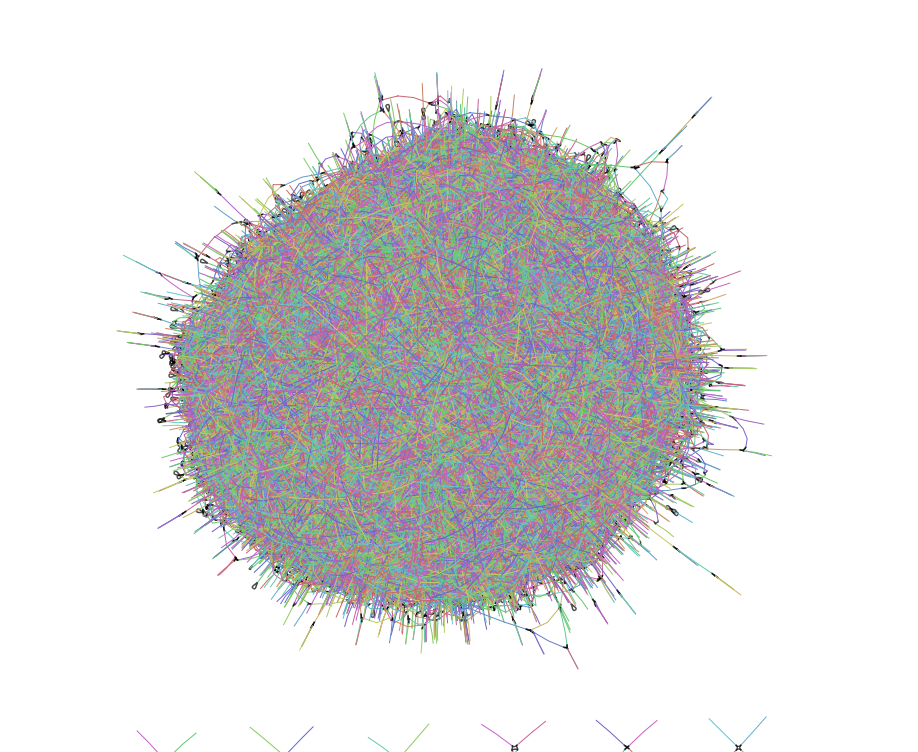



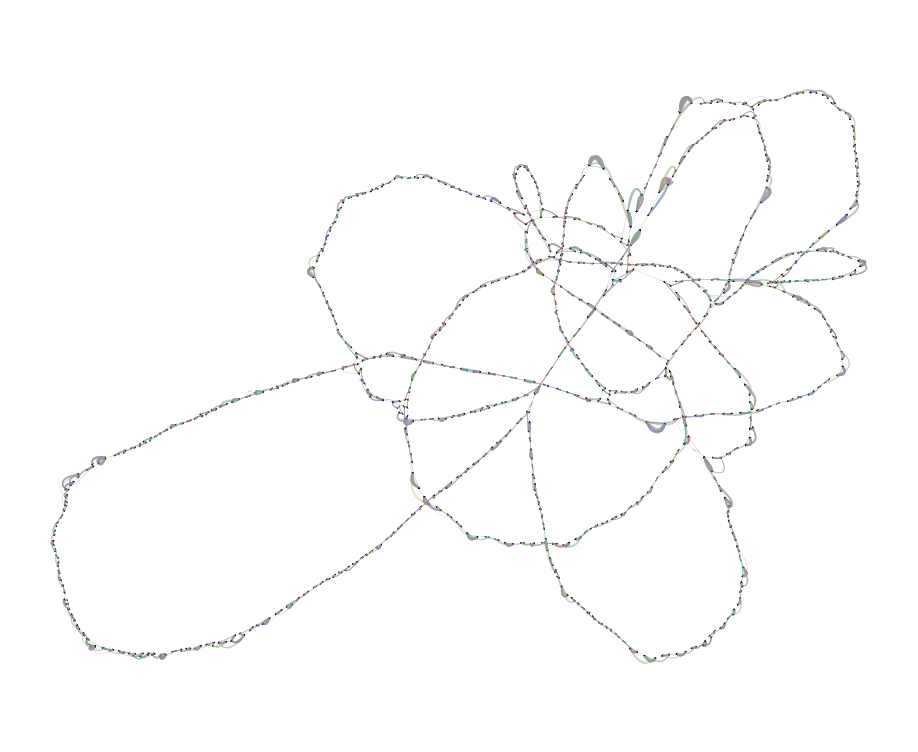

Local View:

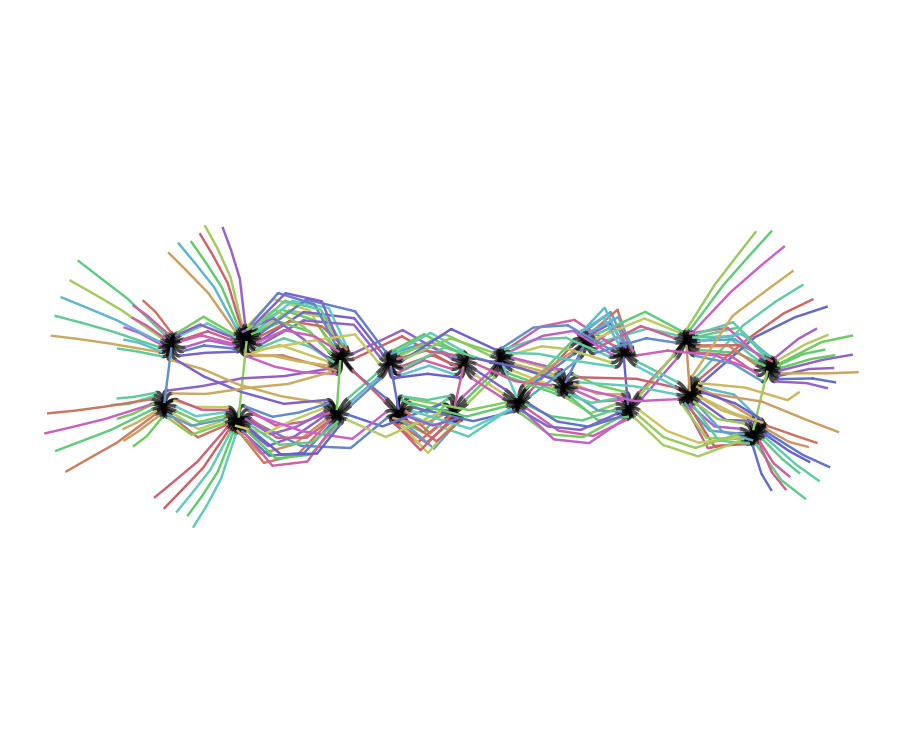

In [100]:
# load graph

nodefile = "/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_HPRC_nodes.fa"
edgefile = "/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_HPRC_edges.fa"
graph = CCGG.GraphicalGenome(nodefile, edgefile, nnamelen=7, enamelen=11)

In [101]:
Outgoing = {}
Incoming = {}
edgelist = list(graph.edges.keys())
for edge in edgelist:
    src = graph.edges[edge]['src']
    dst = graph.edges[edge]['dst']
    Outgoing[src] = Outgoing.get(src, []) + [edge]
    Incoming[dst] = Incoming.get(dst, []) + [edge]

# statistics

In [102]:
# graph size
nodelist = list(graph.nodes.keys())
edgelist = list(graph.edges.keys())
graph_size = sum([len(graph.nodes[node]['seq']) for node in nodelist]) + sum([len(graph.edges[edge]['seq']) for edge in edgelist])

In [103]:
#graph.nodes['A000001'], graph.edges["E00000.0001"]
graph_size, 191670674, graph_size/191670674.0

(429159, 191670674, 0.0022390436212479745)

Text(0, 0.5, 'Num of Anchor')

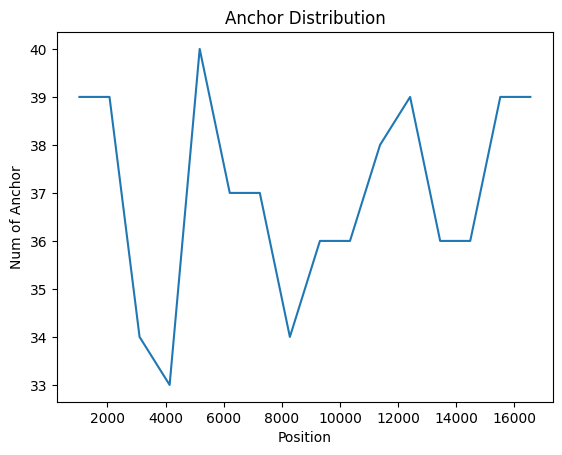

In [104]:
Anchor_position = sorted([graph.nodes[node]['pos'] for node in nodelist])

y, x = numpy.histogram(Anchor_position, bins = 16)
plot.plot(x[1:], y)
plot.title("Anchor Distribution")
plot.xlabel("Position")
plot.ylabel("Num of Anchor")

In [105]:
A = numpy.array(Anchor_position)
numpy.median(A[1:]-A[:-1])

24.0

Text(0.5, 1.0, 'Outdegree Distribution')

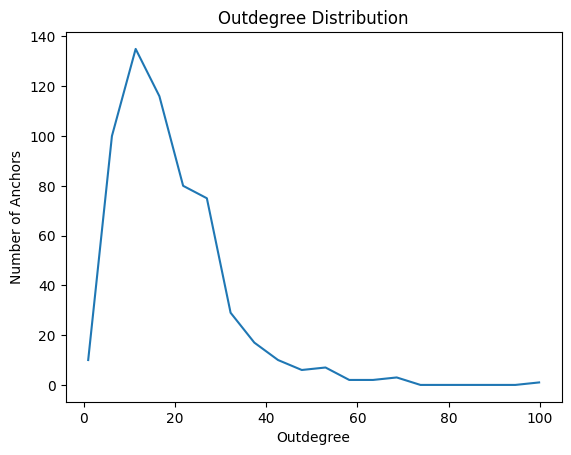

In [106]:
outdegree = []
nodelist = list(Outgoing.keys())
nodelist.remove("SOURCE")
for node in nodelist:
    outdegree.append(len(Outgoing[node]))
    
y,x = numpy.histogram(outdegree, bins = 20)
plot.plot(x[:-1], y)
#plot.xlim([0,1000])
plot.xlabel("Outdegree")
plot.ylabel("Number of Anchors")
plot.title("Outdegree Distribution")

Text(0.5, 1.0, 'Indegree Distribution')

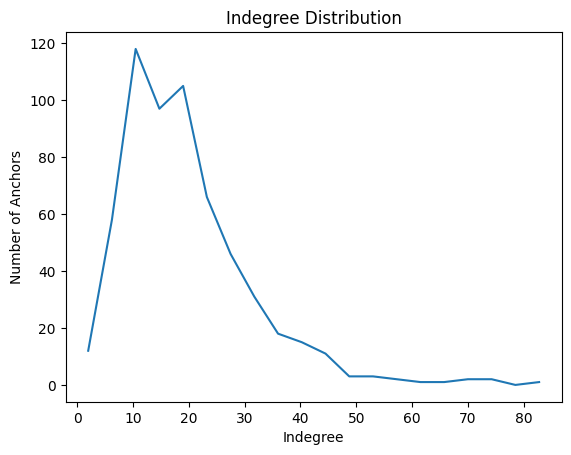

In [107]:
indegree = []
nodelist = list(Incoming.keys())
nodelist.remove("SINK")
for node in nodelist:
    indegree.append(len(Incoming[node]))
    
y,x = numpy.histogram(indegree, bins = 20)
plot.plot(x[:-1], y)

plot.xlabel("Indegree")
plot.ylabel("Number of Anchors")
plot.title("Indegree Distribution")

# Extranct single sample graph

## HG002

In [108]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/HG002_MTreads.fasta'
HG002_headers, HG002_sequences = loadFasta(filename)

In [109]:
# construct Subgraph
readset = set(HG002_headers)
Edge_dict = {}
edgelist = sorted(graph.edges.keys())
for edge in edgelist:
    reads = graph.edges[edge]['reads']
    if len(set(reads) & readset) > 0:
        Edge_dict[edge] = graph.edges[edge]


In [110]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_anchor_graphical_genome_HG002.gfa'
write_gfa(graph.nodes, Edge_dict, filename, list(graph.nodes.keys()))

In [111]:
Outgoing = {}
for edge in Edge_dict:
    src = Edge_dict[edge]['src']
    Outgoing[src] = Outgoing.get(src,[]) + [edge]
    

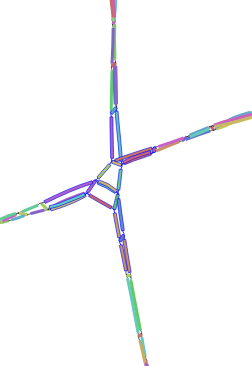

In [189]:
itemlist = ['A000489', 'A000491', 'A000493', 'A001258', 'A001261', 'A001264', 'E00000.0288', 
'E00000.0289', 'E00000.0290', 'E00001.0158', 'E00001.0159', 'E00005.0105', 'E00005.0106', 
'E00005.0107', 'E00006.0025', 'E00007.0003', 'E00009.0277', 'E00009.0278', 'E00009.0279', 
'E00009.0280', 'E00009.0572', 'E00009.0573', 'E00014.0063']

for edge in itemlist:
    if edge.startswith('A'):
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']
        print(edge, graph.nodes[src]['pos'], graph.nodes[dst]['pos'], 
              len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        continue

E00000.0288 5355 5373 9576 CACCTCA
E00000.0289 5373 5390 10051 CCCCAT
E00000.0290 5390 5414 9736 TAAAAATAAAATG
E00001.0158 13836 13869 10328 TCAACTACCTAACCAACAAACT
E00001.0159 13869 13900 9360 CCCCACTATGCACATTTTAT
E00005.0105 5390 13869 23 
E00005.0106 13869 5414 23 G
E00005.0107 5414 5455 8 ATACAAAACCCACCCATTCCTCCCACAC
E00006.0025 5414 5455 77 ATACAAAACCCACCCCCATTCCTCCCCACAC
E00007.0003 5390 5414 112 TAAAAATAAATG
E00014.0063 13480 13579 17 CCTCACAGTTTCTACTCCAAAGACCACATCATCGAAACCGCAAACATATCATACACAAACGCCTGAGCCCTATCTATTACTCTCATC


In [47]:
itemlist = ['A000372', 'A000374', 'A000381', 'A000383', 'A000385', 'A000387', 
            'A000388', 'A000858', 'A000860', 'A000862', 'A000864', 'A000865', 'E00000.0238', 'E00000.0239', 
            'E00000.0240', 'E00000.0241', 'E00000.0242', 'E00000.0243', 'E00000.0244', 'E00001.0008', 
            'E00001.0009', 'E00001.0010', 'E00001.0011', 'E00001.0012', 'E00001.0182', 'E00002.0015', 
            'E00002.0016', 'E00005.0096', 'E00005.0097', 'E00005.0098', 'E00005.0130', 'E00005.0132', 
            'E00006.0018', 'E00006.0019', 'E00006.0020', 'E00006.0046', 'E00009.0136', 'E00009.0137', 
            'E00009.0138', 'E00009.0139', 'E00009.0140', 'E00009.0141', 'E00009.0324', 'E00009.0325', 'E00009.0326', 
            'E00009.0327', 'E00009.0328', 'E00009.0329', 'E00009.0330', 'E00010.0005', 'E00014.0018']
for edge in itemlist:
    if edge.startswith('A'):
        print(graph.nodes[edge]['pos'])
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']
        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
              len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        continue

4091
4112
4190
4211
4225
4248
4266
9431
9455
9475
9494
9509
E00000.0238 A000370 4061 A000372 4091 10692 ACAACATATTTTGTCACCA
E00000.0239 A000372 4091 A000374 4112 4609 CTAACCTCCC
E00000.0240 A000374 4112 A000381 4190 8802 ATTCGAACAGCATACCCCCGATTCCGCTACGACCAACTCATACACCTCCTATGAAAAAACTTCCTAC
E00000.0241 A000381 4190 A000383 4211 10754 GCATTACTTA
E00000.0242 A000383 4211 A000385 4225 10844 TCC
E00000.0243 A000385 4225 A000387 4248 8859 AATCTCCAGCAT
E00000.0244 A000387 4248 A000388 4266 9023 CCTAAGA
E00001.0008 A000856 9409 A000858 9431 10556 ACACCACCTGT
E00001.0009 A000858 9431 A000860 9455 10158 TTCGATACGGGAT
E00001.0010 A000860 9455 A000864 9494 389 TTACCTCAGAAGTTTTTTTTCTTCGCAGG
E00001.0011 A000864 9494 A000865 9509 10796 CCTT
E00001.0012 A000865 9509 A000867 9530 3030 GCCTAGCCCC
E00001.0182 A000370 4061 A000372 4091 74 ACAACATATTTTTGTCACCA
E00002.0015 A000860 9455 A000862 9475 10087 TTACCTCAG
E00002.0016 A000862 9475 A000864 9494 9925 TTCGCAGG
E00005.0096 A000370 4061 A000372 4091 75 ACA

In [48]:
edge = 'E00006.0020'
readname = list(set(graph.edges[edge]['reads']) & readset)[0]
Read_dict = dict(zip(HG002_headers, HG002_sequences))
read_seq = Read_dict[readname]

In [49]:
A, SV = mapping_info(Anchorseq, read_seq, k)
A['A000862'], A['A000381'], A

(6990,
 7006,
 {'A000001': 2816,
  'A000003': 2845,
  'A000005': 2865,
  'A000008': 2894,
  'A000009': 2911,
  'A000011': 2927,
  'A000013': 2954,
  'A000014': 2966,
  'A000016': 2985,
  'A000018': 3008,
  'A000020': 3023,
  'A000023': 3059,
  'A000025': 3079,
  'A000026': 3095,
  'A000031': 3147,
  'A000033': 3168,
  'A000035': 3197,
  'A000038': 3232,
  'A000040': 3245,
  'A000045': 3304,
  'A000046': 3317,
  'A000048': 3335,
  'A000052': 3385,
  'A000054': 3403,
  'A000056': 3430,
  'A000059': 3455,
  'A000063': 3502,
  'A000064': 3518,
  'A000067': 3544,
  'A000071': 3591,
  'A000075': 3632,
  'A000078': 3669,
  'A000080': 3693,
  'A000082': 3707,
  'A000087': 3762,
  'A000090': 3800,
  'A000096': 3868,
  'A000099': 3901,
  'A000101': 3923,
  'A000103': 3946,
  'A000105': 3967,
  'A000107': 3992,
  'A000110': 4016,
  'A000112': 4045,
  'A000116': 4085,
  'A000117': 4097,
  'A000118': 4113,
  'A000120': 4133,
  'A000125': 4181,
  'A000126': 4193,
  'A000128': 4221,
  'A000131': 4255

In [73]:
itemlist = ["A000026", 'A000031',  'E00000.0111', 'E00001.0173', 'E00002.0003', 
            'E00004.0004', 'E00008.0019', 'E00014.0037']
#[E00000.0111, E00001.0173, E00002.0003, E00004.0004, E00008.0019, E00014.0037]
for edge in itemlist:
    if edge.startswith('A'):
        print(graph.nodes[edge]['pos'])
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']
        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
              len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        continue

282
332
E00000.0111 A000026 282 A000031 332 1016 TTCCACCAAACCCCCCCCCTCCCCCCGCTTCTGGCCACAGCA
E00001.0173 A000026 282 A000031 332 3648 TTCCACCAAACCCCCCCCTCCCCCCGCTTCTGGCCACAGCA
E00002.0003 A000026 282 A000031 332 63 TTCCACCAAACCCCCCCCCTCCCCCCCGCTTCTGGCCACAGCA
E00004.0004 A000026 282 A000031 332 3433 TTCCACCAAACCCCCCCTCCCCCCGCTTCTGGCCACAGCA
E00008.0019 A000026 282 A000031 332 205 TTCCACCAAACCCCCCCCCCTCCCCCCGCTTCTGGCCACAGCA
E00014.0037 A000026 282 A000031 332 46 TTCCACCAAACCCCCCCCCTCCCCCGCTTCTGGCCACAGCA


In [62]:
seq = "TTCCACCAAACCCCCCCCTCCCCCCGCTTCTGGCCACAGCACTTAAACACAT"
''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(seq)])

'ATGTGTTTAAGTGCTGTGGCCAGAAGCGGGGGGAGGGGGGGGTTTGGTGGAA'

# HG00735

In [112]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/HG00735_MTreads.fasta'
HG00735_headers, HG00735_sequences = loadFasta(filename)

In [113]:
# construct Subgraph
readset = set(HG00735_headers)
Edge_dict = {}
edgelist = sorted(graph.edges.keys())
for edge in edgelist:
    reads = graph.edges[edge]['reads']
    if len(set(reads) & readset) > 0:
        Edge_dict[edge] = graph.edges[edge]
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_anchor_graphical_genome_HG00735.gfa'
write_gfa(graph.nodes, Edge_dict, filename, list(graph.nodes.keys()))

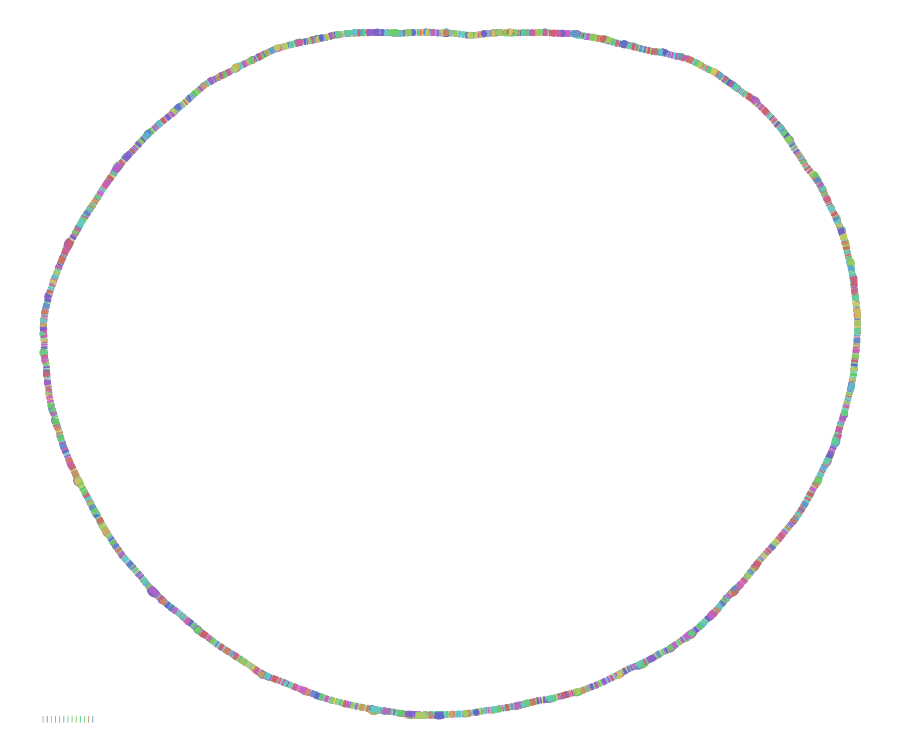HG00735_overview.png

In [74]:
itemlist = ['E00001.0022', 'E00002.0018', 'E00078.0027', 'E00712.0029', 'E00722.0033', 'E00727.0039']
for edge in itemlist:
    if edge.startswith('A'):
        print(graph.nodes[edge]['pos'])
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']
        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
              len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        continue

E00001.0022 A000888 9760 A000894 9827 180 TCCGACGGCATCTACGGCTCAACATTTTTTTGTAGCCACAGGCTTCCACGGACTTCA
E00002.0018 A000888 9760 A000894 9827 9605 TCCGACGGCATCTACGGCTCAACATTTTTTGTAGCCACAGGCTTCCACGGACTTCA
E00078.0027 A000888 9760 A000894 9827 263 TCCGACGGCATCTACGGCTCAACATTTTTGTAGCCACAGGCTTCCACGGACTTCA
E00712.0029 A000888 9760 A000894 9827 11 TCCGACGGCATCTACGGCTCAAACATTTTTTGTAGCCACAGGCTTCCACGGACTTCA
E00722.0033 A000888 9760 A000894 9827 37 TCGACGGCATCTACGGCTCAACATTTTTTGTAGCCACAGGCTTCCACGGACTTCA
E00727.0039 A000888 9760 A000894 9827 7 TCCGACGGCATCTACGGCTCAACATTTTTTGTAGCCACAGGCTTCCACGGACTTTCA


# Hypervariable regions

Map Locus   Starting    Ending  Shorthand   Description

MT-HV1      16024       16383   CR:HVS1/HV1 Hypervariable segment 1 
                                            [classic:16024-16365]
                                            
MT-HV2      57          372     CR:HVS2     Hypervariable segment 2
                                            [classic:73-340 ]   
                                            
MT-HV3      438         574     CR:HVS3     Hypervariable segment 3

In [7]:

    
def find_region(spos, epos, Final_anchor):
    Anchortable = numpy.array([int(Final_anchor[anchor]['pos']) for anchor in Final_anchor])
    Anchortable = sorted(Anchortable)
    Anchorlist = sorted(Final_anchor.keys())
    sindex = numpy.searchsorted(Anchortable, spos)-1
    eindex = numpy.searchsorted(Anchortable, epos)
    sanchor = Anchorlist[sindex]
    eanchor = Anchorlist[eindex]
    i = sindex
    itemlist = []
    while i != eindex:
        node = Anchorlist[i]
        edgelist = Outgoing.get(node, [])
        print(node+ ",",)
        itemlist.append(node)
        for edge in edgelist:
            print(edge+',',)
            itemlist.append(edge)
        i = i+1
        
    return itemlist

In [ ]:
# m.3394T>C MT-ND1 variants, 
# which is associated with a complex I enzyme defect and the mtDNA disease Leber hereditary optic neuropath.



In [10]:
# m.3242 A>G tRNA (Leu UUR)
nodelist = sorted(graph.nodes.keys())
Final_anchor = {node:graph.nodes[node] for node in nodelist}
spos = 3243
epos = 3244

itemlist = find_region(spos, epos, Final_anchor)

itemlist += ['E00000.0214', 'E00003.0019', 'E00055.0001', 'E00095.0045', 'E00112.0004', 'E00128.0044', 
             'E00129.0004', 'E00153.0011', 'E00155.0020', 'E00206.0003', 'E00229.0006', 'E00262.0014', 
             'E00264.0015', 'E00283.0033', 'E00346.0005', 'E00373.0002', 'E00444.0008', 'E00452.0007', 
             'E00724.0016', 'E00738.0033', 'E00745.0029', 'E00755.0014', 'E00812.0002', 'E00842.0013', 
             'E00881.0022', 'E00882.0012', 'E00985.0016', 'E01013.0005', 'E01039.0001', 'E01046.0005', 
             'E01131.0001', 'E01409.0024', 'E01420.0015', 'E01432.0003', 'E01535.0010', 'E01538.0011', 
             'E01556.0040', 'E01575.0022', 'E01592.0012', 'E01622.0005', 'E01679.0012', 'E01919.0016', 
             'E01934.0008', 'E02071.0008', 'E02150.0034', 'E02174.0001', 'E02319.0011', 'E03093.0003', 
             'E03720.0016', 'E03892.0024']
for edge in itemlist:
    if edge.startswith('A'):
        print(graph.nodes[edge]['pos'])
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']
        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
              len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        continue

A000295,
E00000.0213,
E00212.0012,
E00283.0033,
E00746.0021,
E01013.0005,
E01777.0023,
E01919.0016,
E01934.0008,
3234
E00000.0213 A000295 3234 A000296 3246 10879 C
E00212.0012 A000295 3234 A000296 3246 211 
E00283.0033 A000295 3234 A000302 3313 23 CCCGTAATCGCATAAAACTTAAAACTTTACAGTCAGAGGTTCAATTCCTCTTCTTAACAACATACCC
E00746.0021 A000295 3234 A000296 3246 21 CC
E01013.0005 A000295 3234 A000302 3313 15 CCCGGGTAATCGCATAAAACTTAAAACTTTACAGTCAGAGGTTCAATTCCTCTTCTTAACAACATACCC
E01777.0023 A000295 3234 A000296 3246 12 GC
E01919.0016 A000295 3234 A000302 3313 7 CCCGGTAAATCGCATAAAACTTAAAACTTTACAGTCAGAGGTTCAATTCCTCTTCTTAACAACATACCC
E01934.0008 A000295 3234 A000302 3313 11 CCCGGTATCGCATAAAACTTAAAACTTTACAGTCAGAGGTTCAATTCCTCTTCTTAACAACATACCC
E00000.0214 A000296 3246 A000302 3313 9109 ATAAAACTTAAAACTTTACAGTCAGAGGTTCAATTCCTCTTCTTAACAACATACCC
E00003.0019 A000296 3246 A000302 3313 116 ATAAAACTTAAACTTTACAGTCAGAGGTTCAATTCCTCTTCTTAACAACATACCC
E00055.0001 A000296 3246 A000302 3313 98 ATAAAAACTTAAAACTTTACAGTCAGA

In [33]:
Outgoing = {}
edgelist = graph.edges.keys()
for edge in edgelist:
    src = graph.edges[edge]['src']
    Outgoing[src] = Outgoing.get(src,[]) + [edge]

In [35]:
# length heteroplasmy chrM:302
nodelist = sorted(graph.nodes.keys())
Final_anchor = {node:graph.nodes[node] for node in nodelist}

spos = 302
epos = 303
itemlist = find_region(spos, epos, Final_anchor)
itemlist += ['E00035.0010', 'E00037.0019', 'E00103.0001', 'E00134.0034', 'E00144.0001', 
             'E00397.0003', 'E00672.0017', 'E00673.0001', 'E00675.0001', 'E00758.0001', 
             'E01841.0027', 'E01934.0005', 'E02140.0020', 'E02254.0024', 'E02440.0003', 
             'E03432.0009', 'E03681.0004', 'E03687.0002', 'E03836.0001', 'E03916.0035', 
             'E04682.0001', 'E04689.0001', 'E04741.0001', 'E04764.0002', 'E10072.0002']
for edge in itemlist:
    if edge.startswith('A'):
        print(graph.nodes[edge]['pos'])
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']
        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
              len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        continue

A000026,
E00000.0111,
E00001.0173,
E00002.0003,
E00004.0004,
E00008.0019,
E00014.0037,
E00015.0027,
E00029.0004,
E00032.0001,
E00049.0004,
E00082.0002,
E00083.0008,
E00093.0005,
E00102.0001,
E00130.0027,
E00197.0020,
E00210.0020,
E00217.0010,
E00227.0002,
E00324.0007,
E00328.0000,
E00332.0028,
E00344.0003,
E00385.0002,
E00410.0001,
E00587.0003,
E00606.0011,
E00659.0019,
E00661.0010,
E00670.0026,
E00801.0008,
E00896.0003,
E00917.0005,
E00948.0005,
E01104.0003,
E01170.0028,
E01277.0001,
E01280.0005,
E01455.0037,
E01520.0002,
E01575.0015,
E01914.0006,
E01969.0002,
E02313.0009,
E02409.0000,
E02449.0008,
E02567.0001,
E02664.0000,
E03074.0031,
E03407.0034,
E04200.0005,
E04204.0001,
E04208.0006,
E04607.0000,
E05440.0003,
E06635.0000,
E06795.0006,
282
E00000.0111 A000026 282 A000031 332 1016 TTCCACCAAACCCCCCCCCTCCCCCCGCTTCTGGCCACAGCA
E00001.0173 A000026 282 A000031 332 3648 TTCCACCAAACCCCCCCCTCCCCCCGCTTCTGGCCACAGCA
E00002.0003 A000026 282 A000031 332 63 TTCCACCAAACCCCCCCCCTCCCCCCCGCTTCTGGCCACA

In [66]:
# HV1
spos = 16024
epos = 16383
find_region(spos, epos, Final_anchor)

A001456,
E00000.0076,
E00168.0021,
E00169.0030,
E00282.0014,
E00393.0013,
E00532.0008,
E00571.0041,
E00581.0024,
E00716.0003,
E00964.0019,
E01528.0000,
E01753.0011,
E01857.0023,
E04693.0001,
E06088.0011,
E11321.0003,
E11326.0001,
E11452.0014,
A001458,
E00000.0077,
E00001.0169,
E00008.0016,
E00068.0010,
E00074.0050,
E00075.0015,
E00191.0005,
E00212.0007,
E00236.0035,
E00426.0006,
E00798.0000,
E00799.0019,
E00944.0002,
E01077.0002,
E03110.0071,
E03432.0001,
E04683.0006,
A001460,
E00000.0078,
E00014.0045,
E00037.0020,
E00057.0016,
E00340.0003,
E00683.0016,
E01178.0010,
E01502.0042,
E04264.0008,
E06274.0001,
A001461,
E00000.0079,
E00040.0058,
E00086.0001,
E00088.0014,
E00128.0002,
E00162.0066,
E00197.0017,
E00206.0008,
E00505.0006,
E00745.0021,
E00759.0018,
E00849.0016,
E00986.0003,
E01258.0007,
E02001.0001,
E02173.0026,
E02796.0010,
E04291.0004,
E05280.0002,
E06184.0003,
A001464,
E00000.0080,
E00005.0068,
E00006.0006,
E00153.0016,
E00177.0025,
E00219.0045,
E00228.0038,
E00269.0029,
E00286

In [67]:
# HV2
spos = 57
epos = 372
find_region(spos, epos, Final_anchor)

A000005,
E00000.0100,
E00015.0023,
E00017.0001,
E00035.0011,
E00117.0000,
E00134.0035,
E00199.0014,
E00223.0009,
E00750.0002,
E00754.0029,
E00768.0005,
E00881.0012,
E00953.0001,
E01430.0022,
E01441.0014,
E01538.0003,
E01640.0033,
E01644.0012,
E02244.0003,
E02329.0005,
E03459.0044,
E03719.0002,
E03835.0049,
E04157.0006,
E04201.0002,
E04234.0018,
A000008,
E00000.0101,
E00005.0073,
E00052.0016,
E00221.0003,
E00292.0004,
E00521.0000,
E00661.0009,
E00768.0006,
E01646.0004,
E02241.0025,
E03612.0006,
E03704.0064,
E03857.0005,
E04683.0008,
E10061.0000,
A000009,
E00000.0102,
E00040.0053,
E00270.0022,
E01250.0006,
E01519.0042,
E03150.0016,
A000011,
E00000.0103,
E00062.0048,
E00076.0011,
E00278.0011,
E00392.0005,
E00509.0032,
E00587.0004,
E00697.0043,
E00745.0023,
E00831.0002,
E00906.0001,
E00984.0008,
E01422.0019,
E01484.0006,
E01530.0001,
E01540.0004,
E01561.0002,
E01562.0004,
E01599.0045,
E01607.0003,
E01727.0007,
E01771.0002,
E01956.0003,
E02102.0001,
E02176.0008,
E02250.0032,
E03396.0000,
E0

In [68]:
spos = 438
epos = 574
find_region(spos, epos, Final_anchor)

A000040,
E00000.0116,
E00016.0012,
E00057.0012,
E00062.0049,
E00066.0028,
E00068.0007,
E00138.0004,
E00209.0021,
E00212.0010,
E00276.0011,
E00405.0005,
E00974.0000,
E01455.0040,
E01471.0029,
E01745.0034,
E01917.0002,
E01931.0002,
E02011.0008,
E02589.0000,
E04050.0004,
E04051.0013,
E04083.0001,
E05431.0017,
E06376.0019,
A000042,
E00015.0029,
E00016.0013,
E00078.0004,
E00087.0012,
E00209.0022,
E00210.0019,
E00307.0013,
E00346.0057,
E00377.0004,
E00672.0018,
E00782.0020,
E00946.0005,
E01003.0000,
E01611.0025,
E01877.0007,
E01915.0004,
E01926.0010,
E01927.0003,
E01951.0001,
E02112.0005,
E02150.0001,
E02190.0005,
E03383.0003,
E03965.0017,
E04013.0005,
E04015.0008,
E04021.0001,
E04095.0022,
E04282.0001,
E04800.0001,
E05115.0002,
A000045,
E00000.0117,
E00017.0002,
E00057.0011,
E00070.0002,
E00073.0035,
E00114.0009,
E00124.0023,
E00139.0026,
E00324.0006,
E05734.0017,
E05884.0001,
E09682.0018,
E11363.0004,
A000046,
E00000.0118,
E00015.0030,
E00037.0017,
E00052.0013,
E00074.0056,
E00079.0010,
E0

# Hyper variable regions identified in the graph
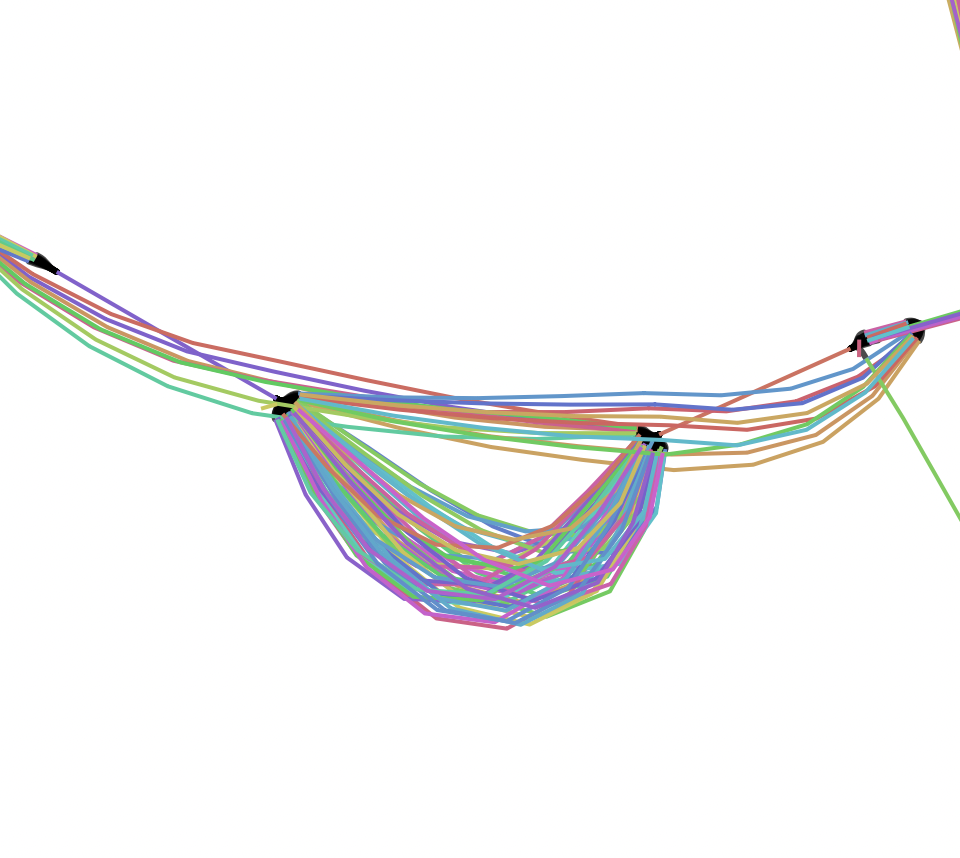

In [38]:
itemlist = ['E00001.0037', 'E00006.0050', 'E00008.0002', 'E00084.0025', 'E00126.0023', 
            'E00138.0009', 'E00162.0020', 'E00171.0011', 'E00214.0002', 'E00257.0001', 
            'E00289.0001', 'E00294.0004', 'E00336.0001', 'E00362.0003', 'E00370.0003', 
            'E00373.0008', 'E00384.0006', 'E00462.0019', 'E00469.0017', 'E00490.0005', 
            'E00518.0011', 'E00526.0002', 'E00529.0003', 'E00562.0018', 'E00613.0010', 
            'E00636.0000', 'E00759.0008', 'E00882.0002', 'E00943.0001', 'E00946.0018', 
            'E00964.0002', 'E01078.0001', 'E01152.0018', 'E01227.0001', 'E01228.0005', 
            'E01520.0017', 'E01522.0003', 'E01545.0002', 'E01650.0010', 'E01681.0002', 
            'E01700.0002', 'E01948.0000', 'E02332.0003', 
            'E02626.0002', 'E02660.0007', 'E04698.0003', 'E09311.0001', 'E09404.0003']

for edge in itemlist:
    if edge.startswith('A'):
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']

        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
          len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        print(edge)

E00001.0037 A000927 10192 A000937 10301 8742 GTCCCTTTCTCCATAAAATTCTTCTTAGTAGCTATTACCTTCTTATTATTTGATCTAGAAATTGCCCTCCTTTTACCCCTACCATGAGCCCTACAAAC
E00006.0050 A000927 10192 A000937 10301 40 GTCCCTTTCTCCATAAAATTCTTCTTAGTAGCTATTACCTTCTTATTATTTGATCTAGAAATTGCCCTCCTTTTTACCCCTACCATGAGCCCTACAAAC
E00008.0002 A000927 10192 A000937 10301 67 GTCCCTTTCTCCATAAATTCTTCTTAGTAGCTATTACCTTCTTATTATTTGATCTAGAAATTGCCCTCCTTTTACCCCTACCATGAGCCCTACAAAC
E00084.0025 A000927 10192 A000937 10301 80 GTCCCTTTCTCCATAAAATTCTTCTTAGTAGCTATTACCTTCTTATTATTTGATCTAGAAATTGCCCTCCTTTTACCCCCTACCATGAGCCCTACAAAC
E00126.0023 A000927 10192 A000937 10301 116 GTCCCTTTCTCCATAAAATTCTTCTTAGTAGCTATTACCTTCTTATTATTTGATCTAGAAATTGCCCTCCTTTTACCCTACCATGAGCCCTACAAAC
E00138.0009 A000927 10192 A000937 10301 31 GTCCCTTTCTCCATAAAATTCTTCTAGTAGCTATTACCTTCTTATTATTTGATCTAGAAATTGCCCTCCTTTTACCCCTACCATGAGCCCTACAAAC
E00162.0020 A000927 10192 A000937 10301 9 GTCCCTTTCTCCATAAAATTCTTCTTAGTAGCTATTACTTCTTATTATTTGATCTAGAAATTGCCCTCCTTTTACCCCTACCATGAGCCCTACAAAC
E00171

In [69]:
itemlist = ['A000777', 'E00001.0279', 'E00003.0030', 'E00019.0058', 'E00022.0005', 'E00040.0026', 
            'E00062.0006', 'E00076.0019', 'E00119.0002', 'E00153.0004', 'E00178.0001', 'E00189.0002', 
            'E00210.0058', 'E00278.0050', 'E00290.0006', 'E00293.0012', 'E00307.0007', 'E00309.0001', 
            'E00332.0013', 'E00333.0025', 'E00369.0017', 'E00373.0011', 'E00421.0002', 'E00462.0013', 
            'E00472.0039', 'E00520.0011', 'E00547.0009', 'E00561.0042', 'E00572.0008', 'E00603.0004', 
            'E00650.0002', 'E00688.0009', 'E00738.0046', 'E00824.0003', 'E00835.0011', 'E00849.0023', 
            'E00976.0012', 'E00992.0036', 'E01082.0018', 'E01099.0001', 'E01213.0003', 'E01238.0004', 
            'E01255.0007', 'E01293.0000', 'E01301.0000', 'E01313.0001', 'E01484.0013', 'E01516.0005', 
            'E01521.0009', 'E01528.0001', 'E01887.0017', 'E01926.0018', 'E02034.0006', 'E02107.0013', 
            'E02314.0001', 'E02532.0016', 'E02927.0000', 'E03007.0012', 'E03080.0001', 'E03200.0001', 
            'E03228.0002', 'E03340.0010', 'E03529.0007', 'E03747.0017', 'E04015.0045', 'E04241.0029', 
            'E04856.0009', 'E04866.0015', 
            'E04905.0014', 'E04970.0005', 'E04988.0018', 'E06576.0003', 'E07688.0001']

for edge in itemlist:
    if edge.startswith('A'):
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']

        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
          len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        print(edge)

E00001.0279 A000768 8440 A000777 8539 8080 TAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAAT
E00003.0030 A000768 8440 A000777 8539 33 TAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCTGAGAACCAAAATGAACGAAAAT
E00019.0058 A000768 8440 A000777 8539 113 TAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAAT
E00022.0005 A000768 8440 A000777 8539 15 TAAACACAAACTACCACCTACCTCCCTCACCAAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAAT
E00040.0026 A000768 8440 A000777 8539 118 TAAACACAAACTACCACCTACCTCCCTCACCAAAGCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAAT
E00062.0006 A000768 8440 A000777 8539 12 TAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTTATAACAAACCCTGAGAACCAAAATGAACGAAAAT
E00076.0019 A000768 8440 A000777 8539 13 TAAACACAAACTACCACCTACCCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAAT
E00119.0002 A000768 8440 A000777 8539 185 TAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAA

In [70]:
itemlist = ['E00001.0268', 'E00005.0120', 'E00006.0041', 'E00015.0093', 'E00019.0055', 'E00037.0003', 
            'E00042.0009', 'E00052.0055', 'E00054.0035', 'E00074.0007', 'E00075.0032', 'E00086.0005', 
            'E00125.0012', 'E00128.0031', 'E00154.0001', 'E00195.0009', 'E00211.0018', 'E00213.0021', 
            'E00278.0046', 'E00283.0068', 'E00309.0002', 'E00332.0015', 'E00346.0025', 'E00394.0015', 
            'E00398.0006', 'E00402.0001', 'E00416.0027', 'E00473.0010', 'E00492.0019', 'E00496.0029', 
            'E00498.0002', 'E00519.0001', 'E00562.0011', 'E00644.0001', 'E00718.0011', 'E00752.0003', 
            'E00777.0013', 'E00782.0063', 'E00783.0008', 'E00804.0011', 'E00892.0005', 'E00986.0011', 
            'E01436.0019', 'E01548.0001', 'E01556.0056', 'E01587.0003', 'E01668.0003', 'E01690.0001', 
            'E01707.0027', 'E01711.0010', 'E01841.0004', 'E01991.0006', 'E02010.0000', 'E02183.0001', 
            'E02241.0007', 'E02242.0021', 'E02952.0009', 'E03060.0026', 'E03436.0023', 'E03465.0004', 
            'E03523.0006', 'E03526.0002', 'E03770.0016', 'E04135.0007', 'E04140.0012', 'E04500.0005', 'E04682.0005', 
            'E04725.0005', 'E04822.0024', 'E05402.0050', 'E05747.0005', 'E06530.0015', 'E07555.0001']

for edge in itemlist:
    if edge.startswith('A'):
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']

        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
          len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        print(edge)

E00001.0268 A000727 7993 A000736 8095 7805 ATCGAGTAGTACTCCCGATTGAAGCCCCCATTCGTATAATAATTACATCACAAGACGTCTTGCACTCATGAGCTGTCCCCACATTAGGCTT
E00005.0120 A000727 7993 A000736 8095 120 ATCGAGTAGTACTCCCGATTGAAGCCCCCATTCGTATAATAATTACATCACAAGACGTCTTGCACTCATGAGCTGTCCCACATTAGGCTT
E00006.0041 A000727 7993 A000736 8095 142 ATCGAGTAGTACTCCCCGATTGAAGCCCCCATTCGTATAATAATTACATCACAAGACGTCTTGCACTCATGAGCTGTCCCCACATTAGGCTT
E00015.0093 A000727 7993 A000736 8095 8 ATCGAGTAGTACTCCCGATTGAAGCCCCCATCGTATAATAATTACATCACAAGACGTCTTGCACTCATGAGCTGTCCCCACATTAGGCTT
E00019.0055 A000727 7993 A000736 8095 10 ATCGAGTAGTACTCCCGATTGAAGCCCCCATTCGTATAATAATTACATCACAAGACGTCTTGCACTCATGAGCTGTCCCCACATTAGGCCTT
E00037.0003 A000727 7993 A000736 8095 164 ATCGAGTAGTACTCCCGATTGAAGCCCCCATTCGTATAATAATTACATCACAAGACGTCTTGCACTCATGAGCTGTCCCCACATTAGGCTTA
E00042.0009 A000727 7993 A000736 8095 153 ATCGAGTAGTACTCCCGATTGAAGCCCCCATTCGTATAATAATTACATCACAAGACGTCTTGCACTCATGAGCTGTCCCCCACATTAGGCTT
E00052.0055 A000727 7993 A000740 8131 61 ATCGAGTAGTACTCCCGATTG

# Structural alterations

In [76]:
itemlist = ['A000381', 'A000862', 'A000864', 'E00000.0240', 
            'E00001.0010', 'E00002.0015', 'E00002.0016', 
            'E00005.0098', 'E00006.0019', 'E00006.0020', 'E00014.0017']

for edge in itemlist:
    if edge.startswith('A'):
        continue
    try:
        src = graph.edges[edge]['src']
        dst = graph.edges[edge]['dst']

        print(edge, src, graph.nodes[src]['pos'], dst, graph.nodes[dst]['pos'], 
          len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])
    except:
        print(edge)

E00000.0240 A000374 4112 A000381 4190 8802 ATTCGAACAGCATACCCCCGATTCCGCTACGACCAACTCATACACCTCCTATGAAAAAACTTCCTAC
E00001.0010 A000860 9455 A000864 9494 389 TTACCTCAGAAGTTTTTTTTCTTCGCAGG
E00002.0015 A000860 9455 A000862 9475 10087 TTACCTCAG
E00002.0016 A000862 9475 A000864 9494 9925 TTCGCAGG
E00005.0098 A000374 4112 A000381 4190 325 ATTCGAACAGCATACCCCGATTCCGCTACGACCAACTCATACACCTCCTATGAAAAAACTTCCTAC
E00006.0019 A000374 4112 A000862 9475 13 ATTCGAACAGCATACCCCCGATTCCGCTACGACCAACTCATACACCTCCTAT
E00006.0020 A000862 9475 A000381 4190 22 CCTAC
E00014.0017 A000374 4112 A000381 4190 79 ATTCGAACAGCATACCCCCGATTCCGCTACGACCAACTCATACACCTCCTATGAAAAACTTCCTAC


#A001343, E00000.0031, E00000.0032, E00009.0537, E00009.0538, E00019.0018, E00019.0019, E00063.0003, E00063.0004
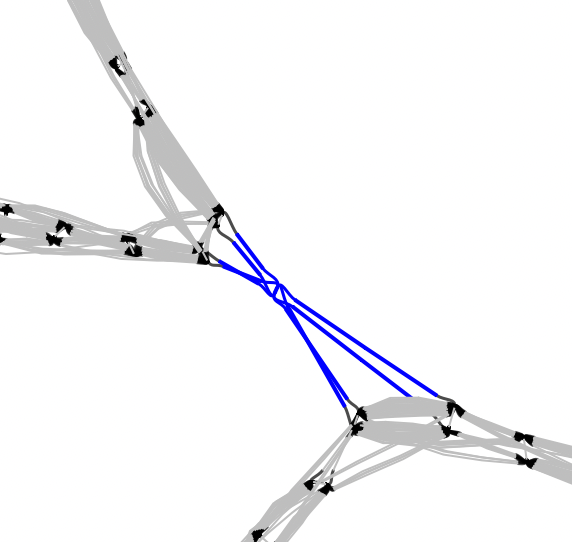

In [21]:
edgelist = ['E00000.0031', 'E00000.0032', 'E00009.0537', 'E00009.0538', 
            'E00019.0018', 'E00019.0019', 'E00063.0003', 'E00063.0004']
for edge in edgelist:
    src = graph.edges[edge]['src']
    dst = graph.edges[edge]['dst']
    print(edge, graph.nodes[src]['pos'], graph.nodes[dst]['pos'], 
          len(set(graph.edges[edge]['reads'])), graph.edges[edge]['seq'])

E00000.0031 14737 14766 37 AAGAACACCAATGACCCCAATACGCAAAA
E00000.0032 14766 14785 39 CTAACCCCCTAATAAAATT
E00009.0537 14785 14766 18 ATAAAATTAATTAACCACT
E00009.0538 14766 14737 19 TGACCCCAATACGCAAAACTAACCCCCTA
E00019.0018 1823 14766 67 ATAGCAAGGA
E00019.0019 14766 1840 67 CTAACCCC
E00063.0003 1840 14766 60 TACCTTCT
E00063.0004 14766 1823 61 TAACCCCCTA


# Another 5 reads
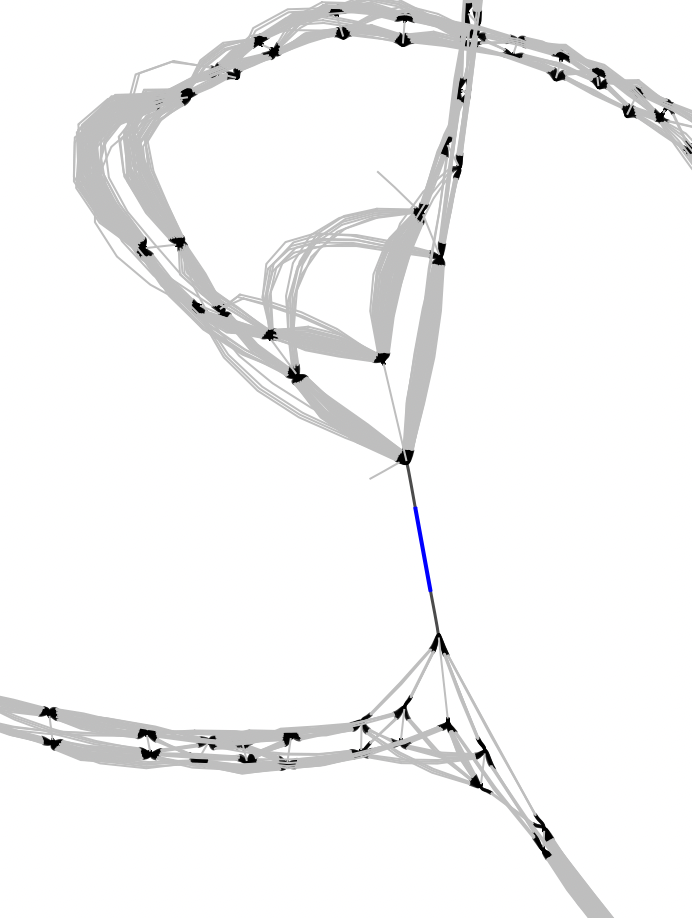

In [26]:
itemlist = ['A000749', 'A001317', 'E00000.0021', 'E00001.0164', 'E00009.0549', 'E00014.0059', 'E00029.0006',
            'E00087.0007', 'E00196.0057', 'E00272.0008', 'E00303.0014', 'E00602.0016', 
            'E01400.0052', 'E01422.0034', 'E01470.0016', 'E01654.0013', 'E01915.0003', 'E03771.0003', 'E05646.0025']

for item in itemlist:
    if item.startswith("A"):
        print(item, graph.nodes[item]['pos'])
    if item.startswith("E"):
        src = graph.edges[item]['src']
        dst = graph.edges[item]['dst']
        print(item, graph.nodes[src]['pos'], graph.nodes[dst]['pos'], 
          len(set(graph.edges[item]['reads'])), graph.edges[item]['seq'])

A000749 8232
A001317 14486
E00000.0021 14486 14501 5264 ATTCCCCCTAAATAA
E00001.0164 14486 14515 300 ATTCCCCCTAAATAAATTAAAAAAAACTAT
E00009.0549 14486 14465 4728 GACAACCATCATTCCCCCTAA
E00014.0059 14486 14450 12 TGTAGTATATCCAAGACAACCATCATTCCCCCTAA
E00029.0006 14486 8232 5 ATTCCCCC
E00087.0007 14486 14501 43 ATTCCCCCTAAATA
E00196.0057 14486 14501 21 ATTCCCCCTAATAA
E00272.0008 14486 14515 113 ATTCCCCCTAAATAAATTAAAAAACTAT
E00303.0014 14486 14465 8 GACAACATCATTCCCCCTAA
E00602.0016 14486 14465 10 GGACAACCATCATTCCCCCTAA
E01400.0052 14486 14465 6 GACACCATCATTCCCCCTAA
E01422.0034 14486 14450 4 TGTAGTATAATCCAAAGACAACCATCATTCCCCCTAA
E01470.0016 14486 14515 5 ATTCCCCCTAAATAAATAAAAAAACTAT
E01654.0013 14486 14465 11 GACAAACCATCATTCCCCCTAA
E01915.0003 14486 14501 5 ATTCCCCCTAAAATAA
E03771.0003 14486 14465 5 AGACAACCATCATTCCCCCTAA
E05646.0025 14486 14450 6 TGTAGTATATCAAAGACAACCATCATTCCCCCTAA


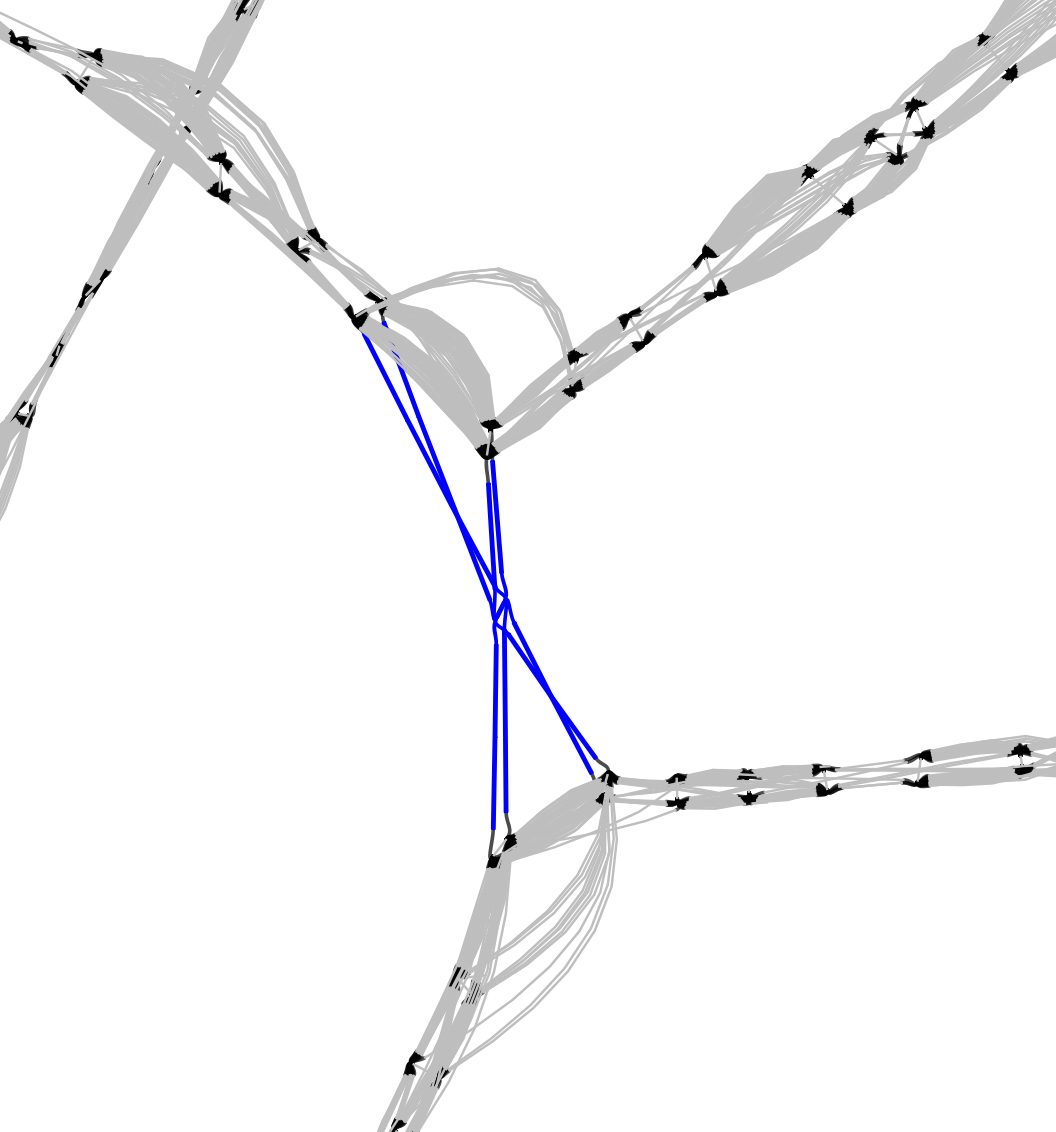

In [27]:
itemlist = ['A000639', 'E00001.0230', 
'E00001.0231', 'E00009.0223', 'E00009.0224', 'E00167.0016', 
'E00167.0017', 'E00782.0041', 'E00782.0042']

for item in itemlist:
    if item.startswith("A"):
        print(item, graph.nodes[item]['pos'])
    if item.startswith("E"):
        src = graph.edges[item]['src']
        dst = graph.edges[item]['dst']
        print(item, graph.nodes[src]['pos'], graph.nodes[dst]['pos'], 
          len(set(graph.edges[item]['reads'])), graph.edges[item]['seq'])

A000639 7019
E00001.0230 6990 7019 51 CTAGACATCGTACTACACGACACGTACTA
E00001.0231 7019 7045 49 CGTTGTAGCCCACTTCCACTATGTCC
E00009.0223 7045 7019 26 ACTTCCACTATGTCCTATCAATAGGA
E00009.0224 7019 6990 26 ACTACACGACACGTACTACGTTGTAGCCC
E00167.0016 3435 7019 5 CTACGGGCTACTAC
E00167.0017 7019 3363 6 CCGAACGAAAAATTCTAGGCTATATACAACTACGCAAAGGCCCCAACGTTGTAGCCC
E00782.0041 3363 7019 8 CCTAATGCTTACCGAACGAAAAATTCTAGGCTATATACAACTACGCAAAGGCCCCAA
E00782.0042 7019 3435 10 CGTTGTAGCCCCTA


# stats

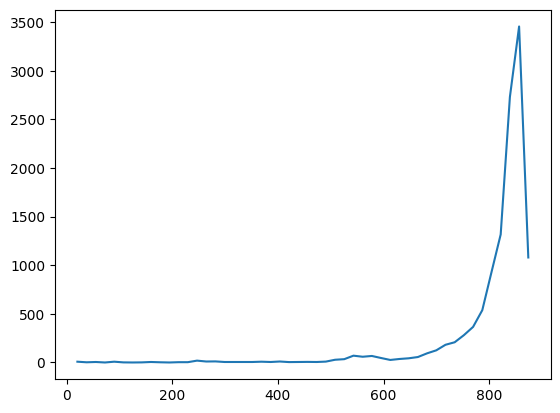

In [40]:
y, x = numpy.histogram(edgenum_perread, bins = 50)
plot.plot(x[1:], y)

In [52]:
#Edge_info

# Too slow by directly traversing graph

In [93]:
Paths = []
maximal = 15
source = pyfrost.Kmer(AnchorInfo[firstnode]['seq'])
target = pyfrost.Kmer(AnchorInfo[secondnode]['seq'])
visited = set()

def find_paths(g, start, end, sofar = [], depth = 0):
    global Paths, maximal, visited
    # termination by node
    
    if str(start) == str(end):   
        sofar1 = sofar
        Paths.append((sofar1))
        return 

    if depth > maximal:
        return  
    depth1 = depth + 1
    
    if start in visited:
        return
    
    for dst in g.successors(start):               
        find_paths(g, dst, end, sofar = sofar + [start], depth = depth1)

find_paths(g, source, target)

In [94]:
for path in Paths:
    seq = pyfrost.path_sequence(g, path)
    print(seq)

GTCTATCACCCAACTACCACTCACGGGA
GTCTATCACCCACCCACTCACGGGA
GTCTATCACCCACTCACGGGA
GTCTATCACCCCTAACCACTCACGGGA
GTCTATCACCCCTAACCCACTCACGGGA
GTCTATCACCCCTATTAACACTCACGGGA
GTCTATCACCCCTTACCACTCACGGGA
GTCTATCACCCTAACCACTCACGGGA
GTCTATCACCCTAACCCACTCACGGGA
GTCTATCACCCTATTAACACTCACGGGA
GTCTATCACCCTTACCACTCACGGGA
GTCTATCACCCTTTTACCCACTCACGGGA


In [ ]:
# find all paths in the graph
firstnode = AnchorInfo[anchor_unadjacent_list[0]]['seq']
secondnode = AnchorInfo[anchor_unadjacent_list[1]]['seq']
EdgeInfo = {}
edgenum = 0
for i in range(len(anchor_unadjacent_list)-1):
    firstnode = anchor_unadjacent_list[i]
    secondnode = anchor_unadjacent_list[i+1]
    distance = AnchorInfo[secondnode]['pos'] - AnchorInfo[firstnode]['pos']
    print(distance)
    Paths = []
    maximal = distance + 1 # enable maximal 3 distance
    visited = set()
    source = pyfrost.Kmer(AnchorInfo[firstnode]['seq'])
    target = pyfrost.Kmer(AnchorInfo[secondnode]['seq'])
    find_paths(g, source, target)
    print(firstnode, len(Paths))
    
    for path in Paths:
        seq = pyfrost.path_sequence(g, path)
        print(seq)
        edgenum += 1
        edgename = "E%08d" % (edgenum)
        EdgeInfo[edgename] = {}
        EdgeInfo[edgename]['src'] = firstnode
        EdgeInfo[edgename]['dst'] = secondnode
        EdgeInfo[edgename]['seq'] = seq
    break
    

19


In [37]:
#print(nx.has_path(G = g, source = AnchorInfo[firstnode]['seq'], target =AnchorInfo[secondnode]['seq'] ))
#nx.all_shortest_paths(G = g, source = firstnode, target = secondnode)

True


In [45]:
#AnchorInfo[firstnode]['seq']

'ATTAATGCTTG'

In [52]:
# Path = nx.shortest_path(G = g, source = AnchorInfo[firstnode]['seq'], target =AnchorInfo[secondnode]['seq'] )
# index = 0
# for path in Path:
#     index += 1
#     print(path, index)

ATTAATGCTTG 1
TTAATGCTTGA 2
TAATGCTTGAG 3
ATGCTTGAGGA 4
TGCTTGAGGAC 5
TGAGGACATAA 6
GAGGACATAAT 7
AGGACATAATA 8
GGACATAATAA 9


In [92]:
#pyfrost.KmerCounter.count_kmers(pyfrost.Kmer('GGACATAATAA'))

TypeError: count_kmers(): incompatible function arguments. The following argument types are supported:
    1. (self: pyfrostcpp.KmerCounter, arg0: str) -> pyfrostcpp.KmerCounter

Invoked with: <Kmer 'GGACATAATAA'>

In [90]:
#help(pyfrost.KmerCounter)

Help on instancemethod in module pyfrostcpp:

count_kmers(...)
    count_kmers(self: pyfrostcpp.KmerCounter, arg0: str) -> pyfrostcpp.KmerCounter



In [ ]:
# visited = set() # Set to keep track of visited nodes of graph.

# def dfs(visited, graph, node):  #function for dfs 
#     if node not in visited:
#         print (node)
#         visited.add(node)
#         for neighbour in graph[node]:
#             dfs(visited, graph, neighbour)

In [49]:
# maxdepth = 25
# start = AnchorInfo[firstnode]['seq']
# end = AnchorInfo[secondnode]['seq']

# depth = 0
# node = start
# path = []
# while depth < maxdepth:
#     for dst in g.successors(node):

In [46]:

# def find_all_path(g, start, end, sofar = [], depth = 0):
#     """
#     Find Cycles
#     Parameters:
#         start: <int> - Start anchor
#         end: <int> - the anchor next to the start anchor
#     """ 
#     global Path, maxlength
    
#     if depth > maxlength:
#         return
    
#     if start == end:   
#         sofar1 = sofar
#         Path.append(sofar1)
#         return 
    
#     for dst in g.successors(start):
#         find_all_path(g, dst, end, sofar = sofar + [start], depth = depth + 1)


In [ ]:
# Path = []
# maxlength = 25
# find_all_path(g, firstnode, secondnode, sofar = [], depth = 0)

In [48]:
#Path

[]

In [15]:
# print(g.nodes['GTCTATCACCC']['unitig_sequence'])
# print
# for kmer in g.successors('GTCTATCACCC'):
#     print(kmer)

GTCTATCACCC
TCTATCACCCA
TCTATCACCCC
TCTATCACCCT


In [105]:
# for src, dst in g.edges:
#     if len(g.nodes[src]['unitig_sequence']) > 12:
#         print(g.nodes[src]['unitig_sequence'], g.nodes[dst]['unitig_sequence'])
#         break
# #     if str(src) == 'TGAACCGAATT':
# #         print(src, dst)
# #         print(g.nodes[src]['unitig_sequence'])
# #         break

AGCTATAAATGAACA TAAATGAACAA


In [99]:
# for kmer in g.successors('TGAACCGAATT'):
#     print(kmer)

AACCGAATTGG
AACCGAATTGT
